<a href="https://colab.research.google.com/github/caduAa/MPLC-/blob/main/MPLC_mys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def split_step(U,region, dz):

  X,Y = region;
  dx, dy = X[1] - X[0], Y[1] - Y[0];
  k_x, k_y = 2. * np.pi * np.fft.fftfreq(50, dx), 2. * np.pi * np.fft.fftfreq(50, dy);
  K_x, K_y = np.meshgrid(k_x, k_y);

  H = np.exp(-1j *dz * np.sqrt((k)**2-(K_x)**2-(K_y)**2));

  return ifft2(H * fft2(U));

<ipython-input-18-f761421446da>:125: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1j *dz * np.sqrt((k)**2-(K_x)**2-(K_y)**2));


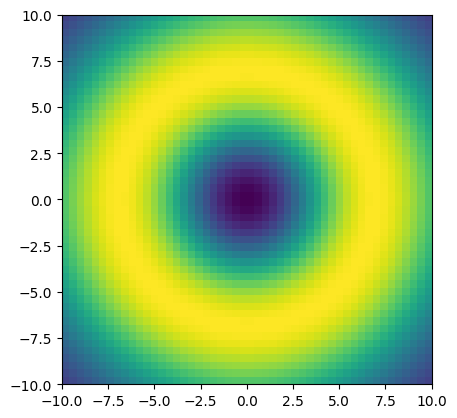

In [ ]:
# For] the field propagation
def split_step(U, H):
  U_fft = np.fft.fft2(U);                                                       #Field's Fourier Transform
  U_propfft = U_fft * H;                                                        # Propagation in Fourier Space
  return np.fft.ifft2(U_propfft);                                               # Back to Real Space

## For initial fields
def gaussian_beam(w0, region):
  j_k = 1j * k;
  z0 = 0.5* k * ((w0)**2);                                                      #Rayleigh range
  W = w0 * np.sqrt(1 + (zList / z0) **2);                                       #Beam waist
  i = 0;
  X,Y = region;
  RHO = np.sqrt(X**2+Y**2);

  R = np.zeros(b);
  for z in zList:
    if z == 0:
      pass
    else:
      R[i] = z * (1 + (z0 / z) **2);
      i = i + 1;

  j_zeta = -1j * z0;
  A0 = 1.;
  A = (w0 / W);
  WW = W ** 2.;

  U = A0 * np.exp(-RHO**2 / W[0] ** 2);

  return U;

def laguerre_gauss_beam(w0, region, l, m):

  j_k = 1j * k;
  z0 = 0.5* k * ((w0)**2);                                                      #Rayleigh range
  W = w0 * np.sqrt(1 + (zList / z0) **2);                                       #Beam waist
  i = 0;
  X,Y = region;
  RHO = np.sqrt(X**2+Y**2);
  PHI = np.arctan(Y/X);

  R = np.zeros(b);
  for z in zList:
    if z == 0:
      pass
    else:
      R[i] = z * (1 + (z0 / z) **2);
      i = i + 1;

  j_zeta = -1j * z0;
  Oz = np.arctan(zList/z0);
  A0 = 1.;
  A = (w0 / W);
  WW = W ** 2.;

  U = A0 * ((RHO / W[0]) ** l) * np.exp(-RHO ** 2 / W[0] ** 2) * np.exp(- (j_k * zList[0]) - 1j * l * PHI + 1j * (l + 2*m + 1) * Oz[0]);                   #terminar

  return U;

#Optimizing...
def optimizing_phases(U1, U2, region, num_interaction = 100):

  numsteps = 250;                                                               #Each step
  phases = [np.random.uniform(0, 2 * np.pi, U1.shape) for step in range(numsteps)];

  carlos_antunis = U1;
  u1 = U2;
  u2 = U2;
  E = U1-U2;
  E_sqr = np.real(np.mean(np.abs(E)**2));

  for i in range(num_interaction):

    j = 0;
    k = 0;

    if E_sqr < 0.1:
      pass
    else:
      for j,k in enumerate(range(numsteps), range(numsteps,0,-1)):

        t1 = np.exp(1j * phases[j]);
        t2 = np.exp(1j * phases[k]);
        U1 = split_step(U1 * t1, H);
        U2 = split_step(U2 * t2, np.conj(H));

    #if E_sqr > 0.1:
      #for j in range(numsteps):                                                 #Loop for phase planes optimization
        phase_diff = np.angle(np.conj(U1) * U2);
    #phases[i] -= learning_rate * phase diff;
        phases[j] = phase_diff;
        E = U1-U2;
        E_sqr = np.real(np.mean(np.abs(E)**2));

    U1 = U3;
    U1, U2 = u1, u2;


  return U1, phases, E_sqr;



##Parameters
l=np.linspace(-10,+10,50);
X, Y = np.meshgrid(l,l);
N = 350;
L = 80;
n0 = 1.5078;
lambda_ = 640e-3;
k0 = 2*np.pi/lambda_;
k = k0*n0;

RHO = np.sqrt(X**2+Y**2);

dx, dy = X[1] - X[0], Y[1] - Y[0];
dz = 20;
zFinal = 5000;
Nz = np.round(zFinal/dz);
Nzint = int(Nz);
zList = np.linspace(0,zFinal, Nzint);
b = zList.size;                                                                 #Number of layers (and steps)
pmlWidth = L/8;
insideIndex = np.round(N*[pmlWidth/L, 1-pmlWidth/L]);
region = (insideIndex[0],insideIndex[1]);

#For Fourier Transform
k_x, k_y = 2. * np.pi * np.fft.fftfreq(50, dx), 2. * np.pi * np.fft.fftfreq(50, dy);
K_x, K_y = np.meshgrid(k_x, k_y);
H = np.exp(-1j *dz * np.sqrt((k)**2-(K_x)**2-(K_y)**2));

##Initial Beam conditions...
w0 = 10.;                               #Beam Waist
beamDist = 0.0;

U1 = gaussian_beam(w0, region = (X,Y));
U2 = laguerre_gauss_beam(w0, region = (X,Y), l = 1, m = 0);
i = 0;

E = U1-U2;
E_sqr = np.real(np.mean(np.abs(E)**2));

numsteps = b;
#pphase = np.random.uniform(0, 2 * np.pi);
a = 1.;
t = 1.;
i = 0;

U3, phases, E_sqr = optimizing_phases(U1, U2, region = (X,Y), num_interaction = 200);

plt.imshow(np.abs(U2) ** 2., extent=[l[0],l[-1],l[0],l[-1]]);




In [ ]:
b = zList.size;
print(b);

250


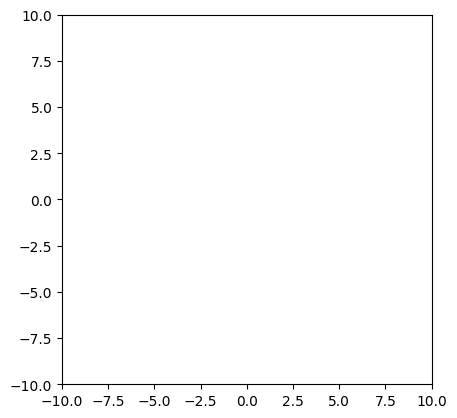

In [ ]:
plt.imshow(np.abs(U3) ** 2., extent=[l[0],l[-1],l[0],l[-1]]);

In [ ]:
U3

array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]])

In [ ]:
E_sqr

0.23070059726810838